In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import missingno as msno
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# 1. Data Description

> Variable	Definition	Key
> survival	Survival	0 = No, 1 = Yes
> pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
> sex	Sex	
> Age	Age in years	
> sibsp	# of siblings / spouses aboard the Titanic	
> parch	# of parents / children aboard the Titanic	
> ticket	Ticket number	
> fare	Passenger fare	
> cabin	Cabin number	
> embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# 2. Check Missing Values & Distribution

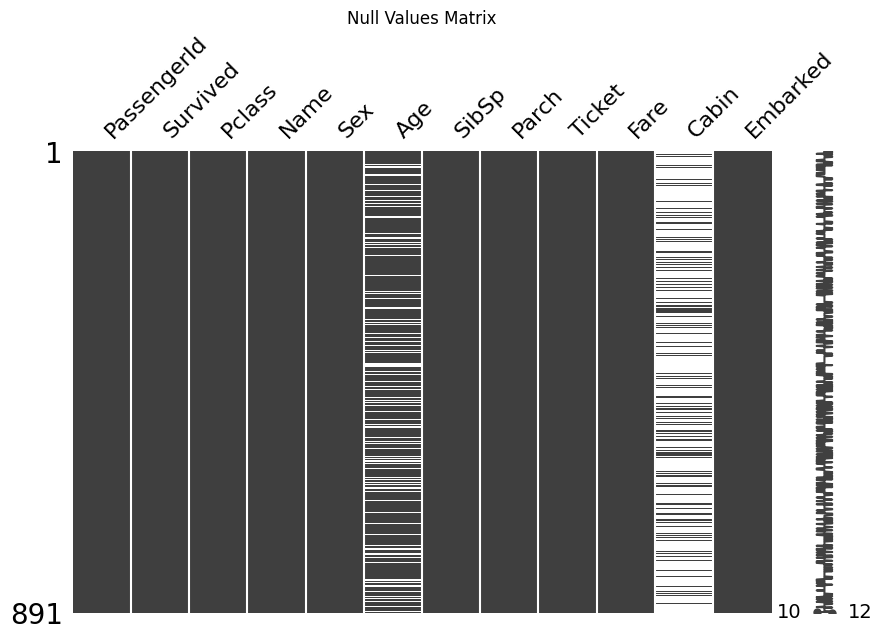

In [3]:
# # Create a heatmap of null values
# plt.figure(figsize=(10, 6))
# sns.heatmap(train.isnull(), cmap='viridis', cbar=False, yticklabels=False)
# plt.title('Null Values Heatmap')
# plt.show()
# Visualize null values using missingno matrix
msno.matrix(train, figsize=(10, 6))
plt.title('Null Values Matrix')
plt.show()

In [4]:
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null 

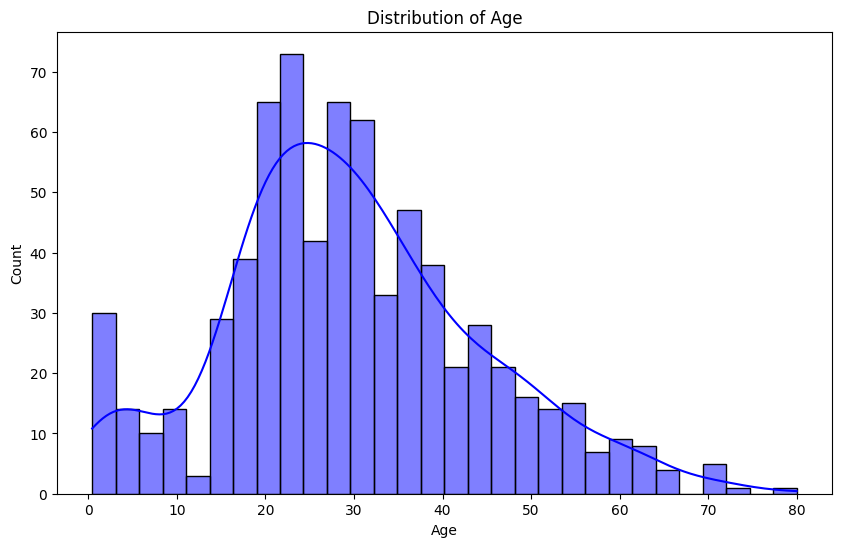

In [5]:
# Visualize the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'].dropna(), bins=30, kde=True, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

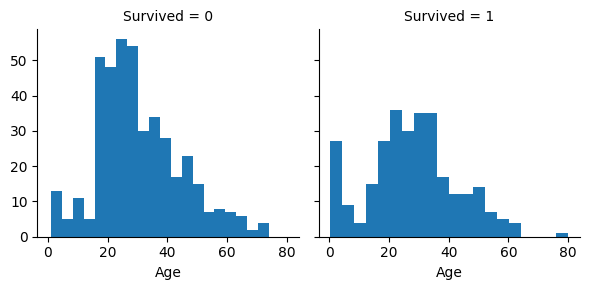

In [6]:
# Visualize the distribution of 'Age'
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

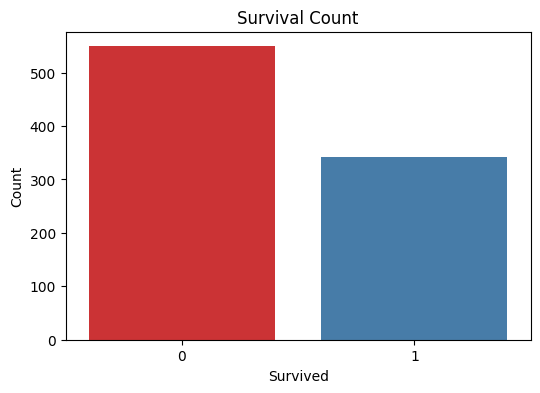

In [7]:
# Visualize the survival count
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train, palette='Set1')
plt.title('Survival Count')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

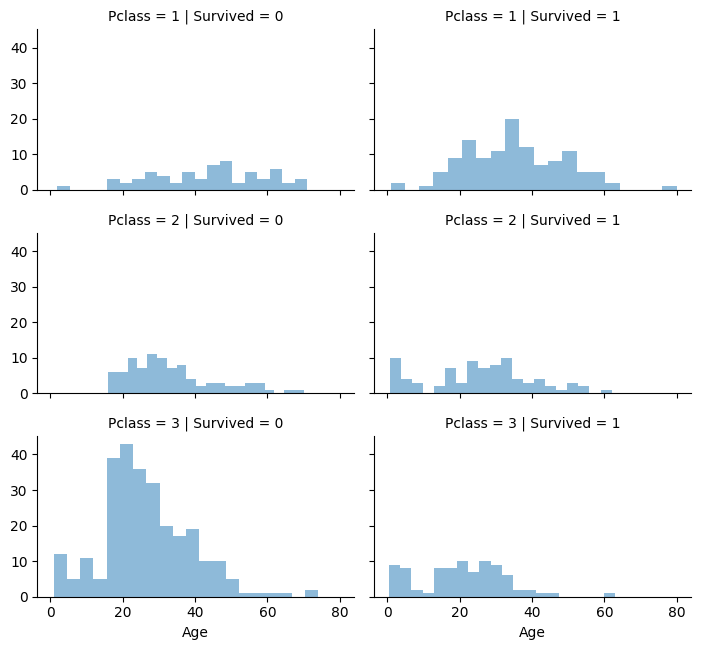

In [8]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

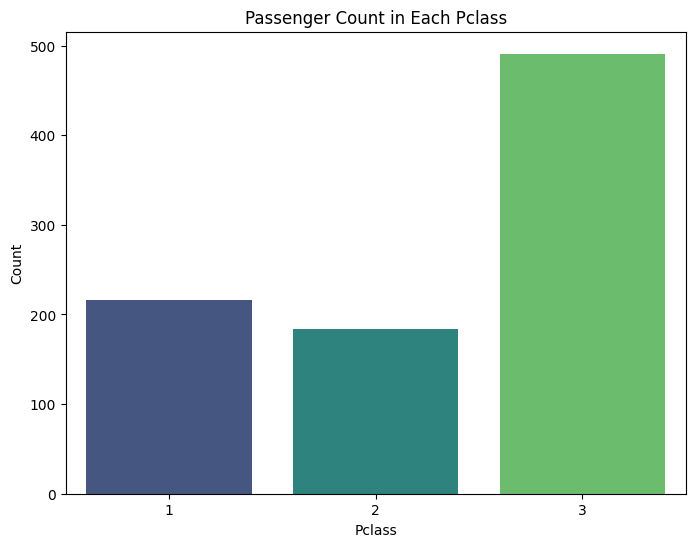

In [9]:
# Visualize the count of passengers in each Pclass
plt.figure(figsize=(8, 6))
sns.countplot(x='Pclass', data=train, palette='viridis')
plt.title('Passenger Count in Each Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

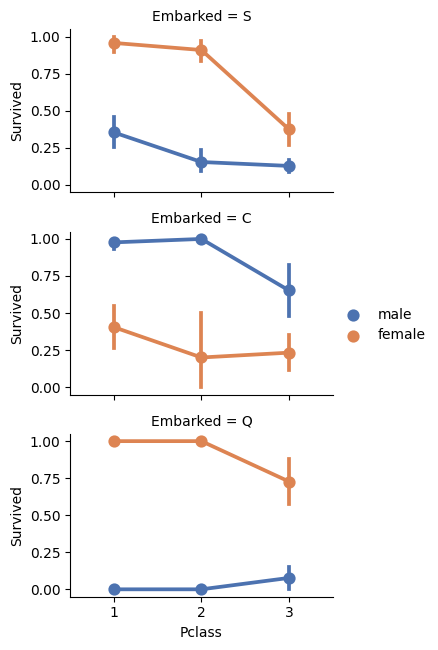

In [10]:
grid = sns.FacetGrid(train, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

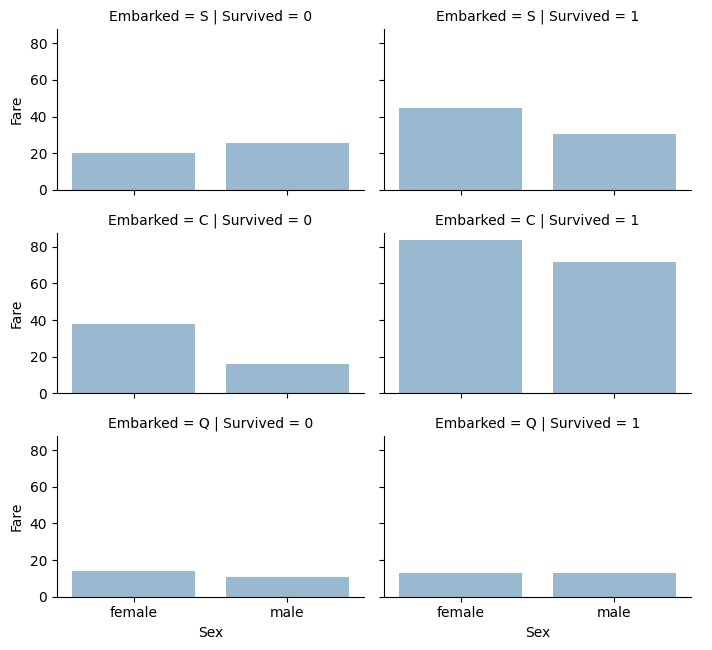

In [11]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

<Axes: title={'center': 'Correlation of Features'}>

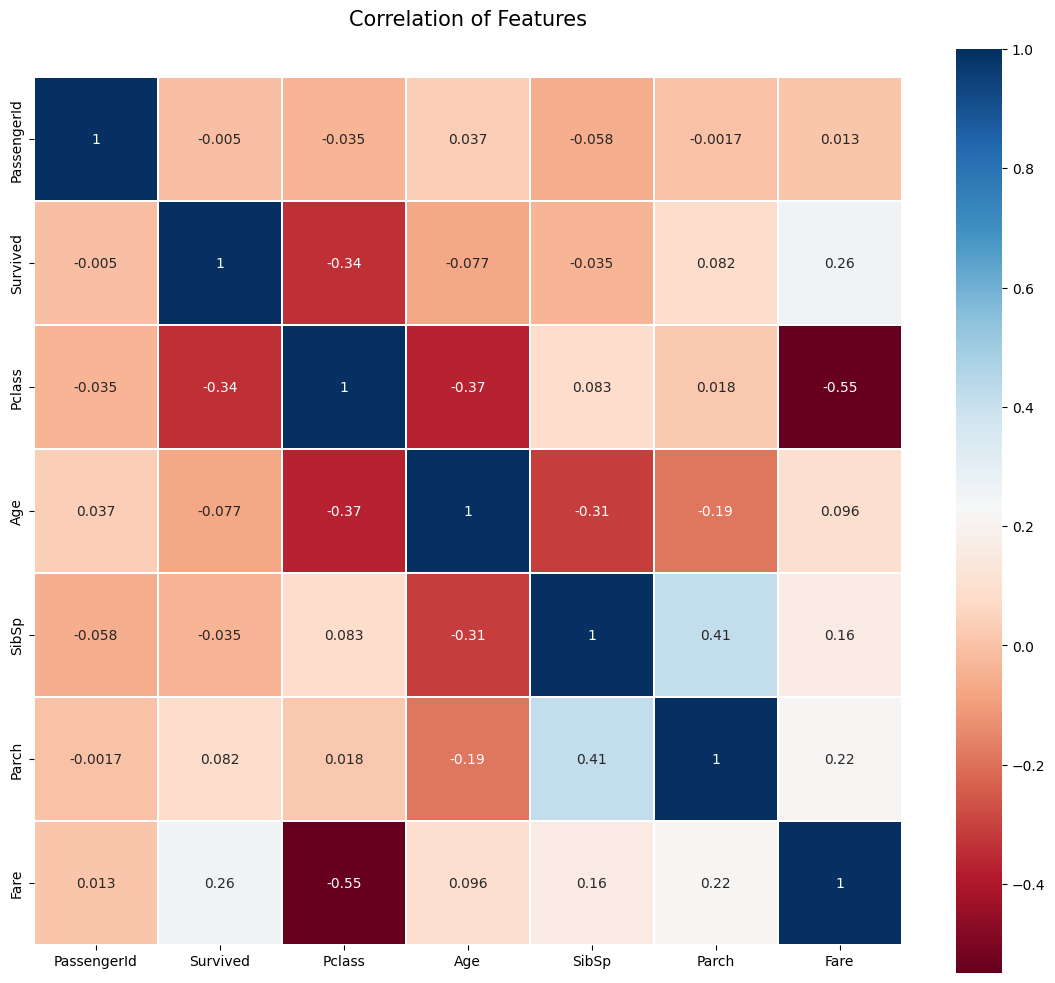

In [12]:
# Visualize the correlation between numeric features
numeric_columns = train.select_dtypes(include=['int64', 'float64'])
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(numeric_columns.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

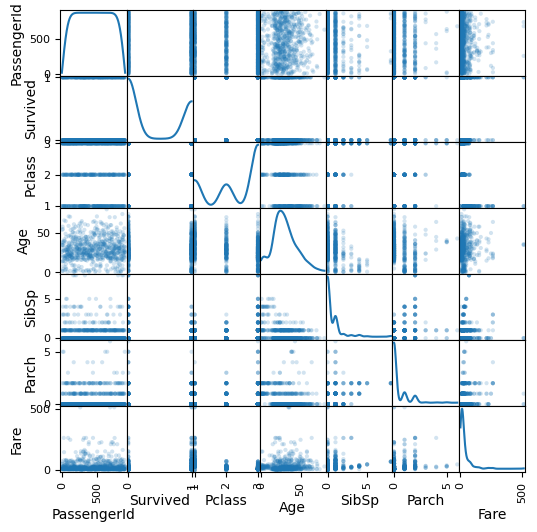

In [13]:
scatter_matrix(train, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

# 3.Check values towards Survival

In [14]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [15]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [16]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [18]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [19]:
#sum(train[train['Fare'] < 8].Survived)
#train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# 2. Handling Missing Values and Adding New Features¶

In [20]:
train_test = pd.concat([train, test], ignore_index=True)
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
# Create a dictionary to store unique cabin names for each ticket number
ticket_cabin_mapping = {}

# Function to generate unique cabin names
def generate_cabin(ticket, cabin):
    if ticket not in ticket_cabin_mapping:
        if pd.notna(cabin):
            return cabin 
        else:
            ticket_cabin_mapping[ticket] = len(ticket_cabin_mapping) + 1
            return f'C_{ticket_cabin_mapping[ticket]}'
    else:
        if pd.notna(cabin):
            return cabin 
        else:
            return f'C_{ticket_cabin_mapping[ticket]}'

# Apply the function to create a new 'Cabin' column
train_test['Cabin'] = train_test.apply(lambda row: generate_cabin(row['Ticket'], row['Cabin']), axis=1)


print(train_test.info())
train_test.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,C_1,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C_2,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C_3,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,C_4,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,C_5,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,C_6,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C_7,C


# Test
>PC 17569

In [22]:
# train_test[train_test['Ticket'] == 'PC 17569']
# train_test[:40]

In [23]:
train_test['Cabin'] = pd.factorize(train_test['Cabin'])[0]
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   int64  
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


In [24]:
train = train_test[train_test['Survived'].notnull()].copy()
train.Survived =train.Survived.astype('int')
test = train_test[train_test['Survived'].isnull()].drop("Survived",axis=1)

In [25]:
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    int64  
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 90.5+ KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 891 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int6

In [26]:
# combining all data
full_data = [train, test]
print("Before", train.shape, test.shape, full_data[0].shape, full_data[1].shape)

train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)
full_data = [train, test]

"After", train.shape, test.shape, full_data[0].shape, full_data[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 11), (418, 10), (891, 11), (418, 10))

In [27]:
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    int64  
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 83.5+ KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 891 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int6

In [28]:
for dataset in full_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [29]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [30]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in full_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,1,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,2,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,3,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,4,S,1


In [31]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
full_data = [train, test]
train.shape, test.shape

((891, 10), (418, 10))

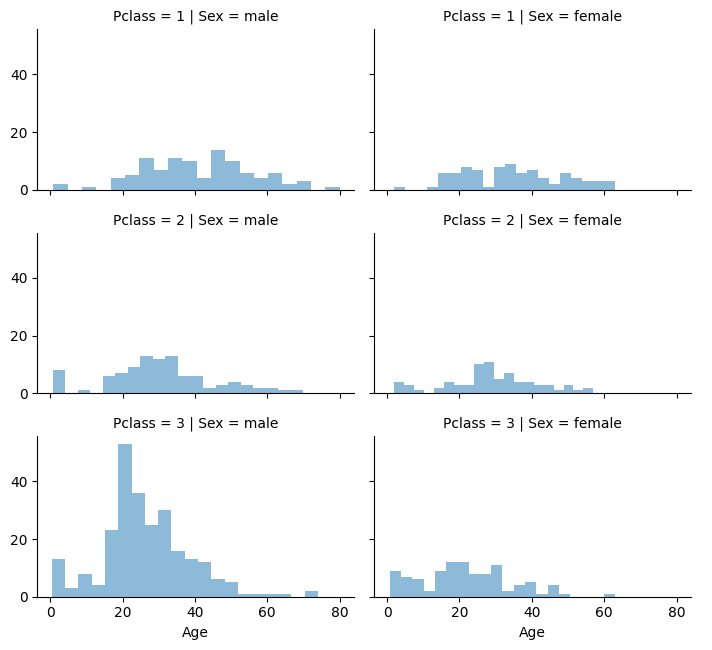

In [32]:
grid = sns.FacetGrid(train, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [33]:
for dataset in full_data:
    # Mapping Gender
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [34]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [35]:
# Initialize guess_ages as a list
guess_ages = []

for dataset in full_data:
    # Initialize guess_ages for each dataset
    guess_ages_dataset = []

    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages_dataset.append(int(age_guess / 0.5 + 0.5) * 0.5)

    guess_ages.append(guess_ages_dataset)

for i, dataset in enumerate(full_data):
    for j in range(0, 2):
        for k in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == j) & (dataset.Pclass == k + 1), 'Age'] = guess_ages[i][j]

    dataset['Age'] = dataset['Age'].astype(int)

# Your code to print the information about the 'train' dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    int64  
 8   Embarked  889 non-null    object 
 9   Title     891 non-null    int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 76.6+ KB


In [36]:
# Define the bins and labels for AGE column
bins_Age = [0, 16, 32, 48, 64, 82]
labels_Age = [1, 2, 3, 4, 5]
for dataset in full_data:
     # Mapping Age
    dataset['Age'] = pd.cut(dataset['Age'], bins=bins_Age, labels=labels_Age, right=False).astype(int)
train.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,1,2,1,0,7.25,0,S,1


In [37]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# train.head(1)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [38]:
for dataset in full_data:
    dataset.loc[(dataset['FamilySize'] == 8) | (dataset['FamilySize'] == 11), 'Chance'] = 0
    dataset.loc[(dataset['FamilySize'] == 5) | (dataset['FamilySize'] == 6), 'Chance'] = 1
    dataset.loc[(dataset['FamilySize'] == 1) | (dataset['FamilySize'] == 7), 'Chance'] = 2
    dataset.loc[(dataset['FamilySize'] == 2) | (dataset['FamilySize'] == 3), 'Chance'] = 3
    dataset.loc[dataset['FamilySize'] == 4, 'Chance'] = 4
        
train[['Chance', 'Survived']].groupby(['Chance'], as_index=False).mean()

,Chance,Survived
0,0.0,0.000000
1,1.0,0.162162
2,2.0,0.304189
3,3.0,0.562738
4,4.0,0.724138


In [39]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
full_data = [train, test]

train.head(1)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Chance
0,0,3,1,2,7.25,0,S,1,3.0


In [40]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [41]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# print(test.info())

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [42]:
for dataset in full_data:
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
    # Convert to integer type
    dataset['Embarked'] = dataset['Embarked'].astype(int)
train.head(3)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Chance
0,0,3,1,2,7.2500,0,0,1,3.0
1,1,1,0,3,71.2833,1,1,3,3.0
2,1,3,0,2,7.9250,2,0,2,2.0


In [43]:
# print(set(train.Age))
# print(set(train.Pclass))

In [44]:
#We can also create an artificial feature combining Pclass and Age.
for dataset in full_data:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,6,2,3
1,3,3,1
2,6,2,3
3,3,3,1
4,9,3,3
5,6,2,3
6,4,4,1
7,3,1,3
8,6,2,3
9,2,1,2


In [45]:
train = train.drop(['Age', 'Pclass'], axis=1)
test = test.drop(['Age', 'Pclass'], axis=1)
full_data = [train, test]
train.head(3)

,Survived,Sex,Fare,Cabin,Embarked,Title,Chance,Age*Class
0,0,1,7.2500,0,0,1,3.0,6
1,1,0,71.2833,1,1,3,3.0,3
2,1,0,7.9250,2,0,2,2.0,6


In [46]:
# Define the bins and labels for Fare column
bins_Fare = [0, 7.91, 14.45, 31, 600]
labels_Fare = [1, 2, 3, 4]

for dataset in full_data:
    # Mapping Fare
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
    dataset['Fare'] = pd.cut(dataset['Fare'], bins=bins_Fare, labels=labels_Fare, right=False).astype(int)

train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=True)

,Fare,Survived
0,1,0.197309
1,2,0.308756
2,3,0.442478
3,4,0.582222


# 4. Data Frame: Make it Ready for Train

In [47]:
test.head(3)

,PassengerId,Sex,Fare,Cabin,Embarked,Title,Chance,Age*Class
891,892,1,1,696,2,1,2.0,9
892,893,0,1,697,0,3,3.0,9
893,894,1,2,698,2,1,2.0,8


In [48]:
testPassengerIds = test.PassengerId
testPassengerIds

891      892
892      893
893      894
894      895
895      896
        ... 
1304    1305
1305    1306
1306    1307
1307    1308
1308    1309
Name: PassengerId, Length: 418, dtype: int64

<Axes: title={'center': 'Correlation of Features'}>

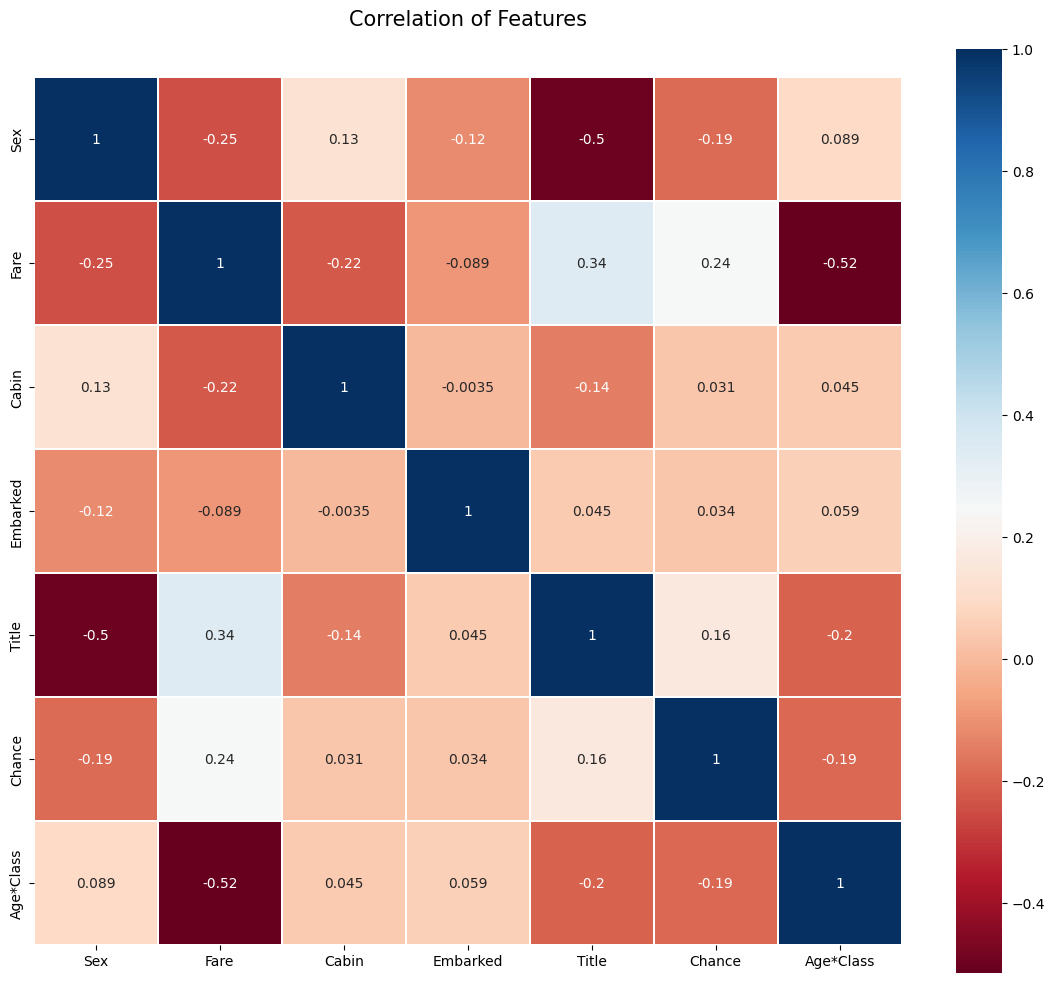

In [49]:
newTrain = train
newTest = test
# Feature selection
# drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin','SibSp','Parch']

survived_train = newTrain['Survived']

newTrain = newTrain.drop(['Survived'], axis = 1)

# newTrain = newTrain.drop(drop_elements, axis = 1)

newTest  = newTest.drop(['PassengerId'], axis = 1)

# print(newTrain.info())
# print(newTest.info())
numeric_columns = newTrain.select_dtypes(include=['int64', 'float64'])
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(numeric_columns.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# 3.Using different Models
>Logistic Regression

>KNN or k-Nearest Neighbors

>Support Vector Machines

>Naive Bayes classifier

>Decision Tree

>Random Forrest

>Perceptron

>Artificial neural network

>RVM or Relevance Vector Machine

# 3.2.Logistic Regression [Predicted(%77)]

In [50]:
# # Logistic Regression
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(newTrain, survived_train)
# Y_pred = logreg.predict(newTest)
# acc_log = round(logreg.score(newTrain, survived_train) * 100, 2)
# acc_log

In [51]:
from sklearn.linear_model import LogisticRegression

#adding Logistic regeression model
logmodel = LogisticRegression(max_iter=10000)

#training model with the train data
logmodel.fit(newTrain, survived_train)

#Try to get the pridiction with data
predictions = logmodel.predict(newTest)
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

# 3.1.Decision Tree Classifier  [Predicted(%72)]

In [52]:
# from sklearn.tree import DecisionTreeClassifier

# # Initialize a Decision Tree Classifier
# model = DecisionTreeClassifier()

# # Train the model
# model.fit(newTrain, survived_train)

# # Make predictions on the test set
# predictions = model.predict(newTest)
# predictions

# 3.3.XGBosst Classifier [Predicted(%00)]

In [53]:
# gbm = xgb.XGBClassifier(
#     #learning_rate = 0.02,
#  n_estimators= 2000,
#  max_depth= 4,
#  min_child_weight= 2,
#  #gamma=1,
#  gamma=0.9,                        
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread= -1,
#  scale_pos_weight=1).fit(newTrain, survived_train)

# #Try to get the pridiction from the train data
# predictions = gbm.predict(newTest)
# predictions

# 4.Submit Answers

In [54]:
df_predictions = pd.DataFrame()
df_predictions['PassengerId'] = pd.Series(testPassengerIds.T.values)
df_predictions['Survived'] = pd.Series(predictions)
df_predictions.to_csv("8th_ClassicTitanic_Attempt.csv", sep=',', index=False)
df_predictions.head(15)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [55]:
# import pandas as pd
# import numpy as np
# sub1=pd.read_csv('../input/titanic-leaked/titanic.csv')
# sub1.to_csv('submission1.csv', index=False)